The function uses a custom calback that 
adjust the learning rate. Initially the learning rate is adjusted by monitoring accuracy. Once the model accuracy
exceeds the level set by parameter threshold, the learning rate is adjusted based on monitoring validation loss.

### Import needed modules

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import time
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML


### surpress tensorflow warnings¶

In [3]:
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

### Define the classifier function and defaut parameters

In [4]:
def classifier(my_dir,                   # main directory 
               save_dir,                 # directory to store the trained model in
               subject,                  # string defining classification subject. Ex 'birds' or 'cars' etc
               model_type = 'Mobilenet', # select from Mobilenet','MobilenetV2', 'VGG19','InceptionV3', 'ResNet50V2', 'NASNetMobile', 'DenseNet201,'EfficientNetB3'3"
               structure = 3,            # 3 for train,test, valid directories, 2 for train, test directories 1 for a single directory dir  
               v_split=.10,              # only valid if structure =1 or 2. Then it is percentage of training images that will be used for validation
               epochs = 15,              # number of epochs to run the model for
               freeze = False,           # if False all layers of the model are trained for epoch epochs, if True layersof basemodel are not trained
               fine_tune_epochs = 10,    # only used when freeze=True, then all model layers are trained for this value epochs after  initial epochs
               height = 224,             # height of images to be used by the model
               width = 224,              # width of images to be used by the model      
               bands = 3,                # bands in image 3 for rgb 1 for grey scale 
               batch_size = 32,          # batch size used in generators
               lr = .001,                # initial learning rate
               patience = 1,             # number of epochs with no performance improvement before learning rate is adjusted
               stop_patience = 3,        # number of times learning rate can be adjusted with performance improvement before stopping training
               threshold = .90,           # float value is training accuracy<threshold adjust lr on accuracy, above threshold adjust on validation loss
               dwell=False,               # if True when there is no performance improvement model weights set back to best_weights
               factor = .5,              # float <1 factor to multiply current learning rate by if performance does not improve
               dropout = .4,             # dropout float<1 defines dropout factor
               print_code=10,             # Integer if 0 no file classifications are printed, if >0 is the maximum number misclassified 
                                         # file classifications that will be printed out
               neurons_a= 128,           # number of neurons in Dense layer between base model and top classification layer
               metrics=['accuracy']):    # create a list of desired metrics Note 'accuracy' metric is automatically added to the list of metrics 
    
    if 'accuracy' not in metrics:
        metrics.append('accuracy')
    # **********NOTE***** if your train, test or validation directories have names different than
    # 'train', or 'test' or ' valid' then use your directory names in the os.path.join statements
    if structure == 3: # define train, test and valid directories where image files are stored within the main dir directory
        train_dir, test_dir, valid_dir =  os.path.join(my_dir, 'train'),  os.path.join(my_dir, 'test'),  os.path.join(my_dir, 'valid')
    elif structure==2: # define train and test directories, no validation directory
        train_dir=os.path.join(my_dir,'train') 
        test_dir= os.path.join(my_dir, 'test')
        valid_dir = None
    else: # the data is in a single directory the dir directory set train directory to my_dir directory
         train_dir, test_dir, valid_dir = my_dir, my_dir, my_dir  
    # create the data generators
    train_gen, test_gen, valid_gen=make_gens(structure, train_dir, test_dir, valid_dir,height, width, bands, batch_size, v_split)
    # display some training images
    show_training_samples(train_gen)
    #create a list of classes from the sub directory names
    class_list=os.listdir(train_dir) # list of class directories within the train directory
    #determine the number of classes
    class_count=0
    for klass in class_list: # iterate through train_dir list, each directory within it is a new class, ignore any files
        klass_path=os.path.join(train_dir, klass)
        if os.path.isdir(klass_path):
            class_count=class_count + 1    
    # make the model basedon input parameters
    model=Models().make_model( model_type,neurons_a, class_count, width, height, bands, lr, freeze, dropout, metrics )
    # determine class weights to handle imbalanced data sets
    class_weight=get_weight_dict(train_dir)
    # create a custom callback using input parameters
        
    callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_type, freeze=freeze, initial_epoch=0 )]
    LRA.tepochs=epochs
    # determine batch sizes for generators and steps per epoch for model.fit
    if structure ==3:# all three generators derived from train, test, valid directory contents
        valid_batch_size, valid_steps = get_bs(valid_dir, batch_size)
        test_batch_size, test_steps = get_bs(test_dir, batch_size)
    elif structure ==2: # train and test generators determined from train and test directories , split train data
                        # into a training generator  and a validation generator
        valid_steps= len(valid_gen.labels)//batch_size + 1
        valid_batch_size= batch_size
        test_batch_size, test_steps=get_bs(test_dir, batch_size) 
    else: # all data is in directory dir
        valid_steps= len(valid_gen.labels)//batch_size + 1
        valid_batch_size=batch_size
        test_steps=valid_steps
        test_batch_size=batch_size
    results=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)
    tr_plot(results, 0)  # plot the loss and accuracy metrics
    model.set_weights(LRA.best_weights) # load the best weights saved during training
    e_dict=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=None, return_dict=True)
    acc=display_eval_metrics(e_dict)
    msg=f'accuracy on the test set is {acc:5.2f} %'
    print_in_color(msg, (0,255,0),(55,65,80))
    save_id=str (model_type +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    save_loc=os.path.join(save_dir, save_id)
    model.save(save_loc)
    preds=model.predict(test_gen, batch_size=test_batch_size, verbose=0, steps=None)
    print_info( test_gen, preds, print_code, save_dir, subject )
    if freeze: # Start Fine Tunning
        msg=f'Fine tuning {model_name} for {str(fine_tune_epochs):3s} epochs'
        print_in_color(msg, (255,255,0), (55,65,80))
        for layer in model.layers:  # make all layers trainable
            layer.trainable==True
        start_epoch=epochs
        total_epochs=start_epoch + fine_tune_epochs
        LRA.reset= True #enables printing of header
        LRA.count=0 # reset counter that counts epochs with no improvement
        LRA.stop_count=0 # reset counter that counts how many consecutive epochs have run with no metric improvement
        LRA.tepochs=total_epochs
        msg=f'Fine tuning {model_name} for {str(fine_tune_epochs):3s} epochs'
        print_in_color(msg, (255,255,0), (55,65,80))
        # train model for fine tunning
        data=model.fit(x=train_gen,  epochs=total_epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,  initial_epoch=start_epoch)
        tr_plot(data, start_epoch)  # plot training graph
        model.set_weights(LRA.best_weights) # load best weights from fine tunning
        save_id=str (model_type +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
        save_loc=os.path.join(save_dir, save_id)
        model.save(save_loc)
        e_dict=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=None, return_dict=True)
        acc=display_eval_metrics(e_dict)
        msg=f'accuracy of fine tuned model on the test set is {acc:5.2f} %'
        print_in_color(msg, (0,255,0),(55,65,80))
        preds=model.predict(test_gen, batch_size=test_batch_size, verbose=0, steps=test_steps)
        #show_images( test_dir, test_gen, preds, max_images)
        print_info( test_dir, test_gen, preds, print_code, save_dir, subject )  

    acc=display_eval_metrics(e_dict)
    msg=' Process complete'
    print_in_color (msg, (0,255,0), (55,65,80))
    return 

### Define function to display sample training images

In [5]:
def show_training_samples(gen):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key        
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=new_dict[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()
    

### Define function to create data generators

In [6]:
def make_gens ( structure, train_dir, test_dir, valid_dir,height, width, bands, batch_size, v_split):
    def scaler(x):
        y=x/127.5-1
        return y
    if bands==3:
        color_mode = 'rgb'
    else:
        color_mode = 'grayscale'
    if structure ==3:
        train_gen=ImageDataGenerator(preprocessing_function=scaler,
                                         horizontal_flip=True).flow_from_directory( train_dir, target_size=(width, height),
                                                                                   batch_size=batch_size, seed=123,
                                                                                   class_mode='categorical', color_mode=color_mode,shuffle=True)   
        valid_batch_size, valid_steps=get_bs( valid_dir, batch_size)
        valid_gen=ImageDataGenerator(preprocessing_function=scaler,
                                        horizontal_flip=False).flow_from_directory(valid_dir,target_size=(width, height),
                                                                                   batch_size=valid_batch_size,
                                                                                   class_mode='categorical',color_mode=color_mode, shuffle=False)
        test_batch_size, test_steps=get_bs(test_dir, batch_size)
        test_gen=ImageDataGenerator(preprocessing_function=scaler,
                                       horizontal_flip=False).flow_from_directory(test_dir, target_size=(width, height),
                                                                                  batch_size=test_batch_size,
                                                                                  class_mode='categorical',color_mode=color_mode, shuffle=False )

        return train_gen, test_gen, valid_gen
    if structure ==2:
        train_gen=ImageDataGenerator(preprocessing_function=scaler,validation_split=v_split,
                                     horizontal_flip=True).flow_from_directory( train_dir, target_size=(width, height), 
                                                                               batch_size=batch_size, seed=123,
                                                                               class_mode='categorical', color_mode=color_mode, subset='training') 
        valid_gen=ImageDataGenerator(preprocessing_function=scaler, validation_split=v_split,
                                    horizontal_flip=False).flow_from_directory( train_dir, target_size=(width, height),
                                                                               batch_size=batch_size, seed=123, shuffle=False,
                                                                               class_mode='categorical', color_mode=color_mode, subset='validation') 
        test_batch_size, test_steps=get_bs(test_dir, batch_size)                                                                                                                         
        test_gen=ImageDataGenerator(preprocessing_function=scaler,
                                    horizontal_flip=False).flow_from_directory(test_dir, target_size=(width, height),
                                                                               batch_size=test_batch_size,
                                                                               class_mode='categorical',color_mode=color_mode, shuffle=False ) 
        return train_gen, test_gen, valid_gen
    train_gen=ImageDataGenerator(preprocessing_function=scaler,validation_split=v_split,
                                     horizontal_flip=True, ).flow_from_directory( train_dir, target_size=(width, height), 
                                                                               batch_size=batch_size, seed=123,
                                                                               class_mode='categorical', color_mode=color_mode, subset='training') 
    valid_gen=ImageDataGenerator(preprocessing_function=scaler, validation_split=v_split,
                                    horizontal_flip=False).flow_from_directory( train_dir, target_size=(width, height),
                                                                               batch_size=batch_size, seed=123, shuffle=False,
                                                                               class_mode='categorical', color_mode=color_mode, subset='validation')
    
    
    test_gen=valid_gen     
    return train_gen, test_gen, valid_gen

### Define function to determine batch size and steps per epoch

In [7]:
def get_bs(dir,b_max):
    # dir is the directory containing the samples, b_max is maximum batch size to allow based on your memory capacity
    # you only want to go through test and validation set once per epoch this function determines needed batch size ans steps per epoch
    length=0
    dir_list=os.listdir(dir)
    for d in dir_list:
        d_path=os.path.join (dir,d)
        length=length + len(os.listdir(d_path))
    batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]  
    return batch_size,int(length/batch_size)

### Create the Models class

In [8]:
class Models:         
    def make_model(self, model_type,neurons_a, class_count, width, height, bands, lr, freeze, dropout, metrics ):
        self.model_type=model_type
        self.class_count=class_count
        self.width=width
        self.height=height
        self.bands=bands
        self.lr=lr   
        self.freeze=freeze
        self.dropout=dropout
        self.metrics=metrics
        self.neurons_a=neurons_a        
        img_shape=(self.width, self.height,self.bands)        
        model_list=['Mobilenet','MobilenetV2', 'VGG19','InceptionV3', 'ResNet50V2', 'NASNetMobile', 'DenseNet201','EfficientNetB0','Xception','InceptionResNetV2']
        if self.model_type not in model_list:
            msg=f'ERROR the model name you specified {self.model_type} is not an allowed model name'
            print_in_color(msg, (255,0,0),(55,65,80))
            return None       
        if self.model_type=='Mobilenet':
            base_model=tf.keras.applications.mobilenet.MobileNet( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet',dropout=.4) 
        elif self.model_type=='MobilenetV2':
            base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet')        
        elif self.model_type=='VGG19':
            base_model=tf.keras.applications.VGG19( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet' )
        elif self.model_type=='InceptionV3':
            base_model=tf.keras.applications.InceptionV3( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet' )
        elif self.model_type=='NASNetMobile':
            base_model=tf.keras.applications.NASNetMobile( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet' )
        elif self.model_type=='DenseNet201':
            base_model=tf.keras.applications.densenet.DenseNet201( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet' )
        elif self.model_type=='EfficientNetB0':
            base_model=tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        elif self.model_type=='Xception':
            base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')  
        elif self.model_type=='InceptionResNetV2':
            base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        else:
            base_model=tf.keras.applications.ResNet50V2( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet')
        
        if self.freeze:
            for layer in base_model.layers:#train top 20 layers of base model
                layer.trainable=False            
        x=base_model.output
        x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
        x = Dense(self.neurons_a, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)
        x=Dropout(rate=dropout, seed=123)(x) 
        #x = Dense(self.neurons_b, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                #bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
        #x=Dropout(rate=dropout, seed=123)(x) 
        output=Dense(self.class_count, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)
        model=Model(inputs=base_model.input, outputs=output)
        
        model.compile(Adamax(lr=self.lr), loss='categorical_crossentropy', metrics=self.metrics) 
        return model

### Define function that prints a string msg in specified foreground and background rgb colors

In [9]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### Define a function that calculates the class_weight dictionary for use in model.fit

In [10]:
def get_weight_dict(dir):    
    most_samples=0
    class_weight={}
    class_list=os.listdir(dir) # dir is the directory with the training samples organized by class    
    for c in (class_list): # iterate through class directories, find number of samples in each class then find class with highest number of samples
        c_path=os.path.join(dir,c)
        if os.path.isdir(c_path):            
            length=len(os.listdir(c_path)) # determine number of samples in the class directory
            if length>most_samples:
                most_samples=length   
    for i,c in enumerate(class_list): #iterate through class directories, find number of samples in each and divide total_samples by length
        c_path=os.path.join(dir,c)
        if os.path.isdir(c_path):
            length=len(os.listdir(c_path)) # number of samples inclass directory
            class_weight[i]=most_samples/length   
            #print (i,most_samples, class_weight[i])   
    return class_weight


### Create subclass of callback class as custom callback to adjust learning rate and save best weights
patience is an integer that specifies how many consecutive epoch can occur until learning rate is adjusted
threshold is a float. It specifies that if training accuracy is above this level learning rate will be adjusted based on validation loss
factor is a float <1 that specifies the factor by which the current learning rate will be multiplied by
class variable LRA.best_weights stores the model weights for the epoch with the lowest validation loss
after train set the model weights with model.load_weights(LRA.best_weights) then do predictions on the test set

In [11]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now        
        if epoch== self.initial_epoch or LRA.reset==True:  
            LRA.reset=False           
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80)) 
            
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(255,0,0)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(255,0,0)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

### define function to plot training results

In [12]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### Define function to print metrics from model.evaluate

In [13]:
def display_eval_metrics(e_data):
    msg='Model Metrics after Training'
    print_in_color(msg, (255,255,0), (55,65,80))
    msg='{0:^24s}{1:^24s}'.format('Metric', 'Value')
    print_in_color(msg, (255,255,0), (55,65,80))
    for key,value in e_data.items():
        print (f'{key:^24s}{value:^24.5f}')
    acc=e_data['accuracy']* 100
    return acc

### Define function to print out information on misclassified images

In [14]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    if len(classes)<= 20:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width=length
            fig_height=length
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)
        

### Example of use 

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


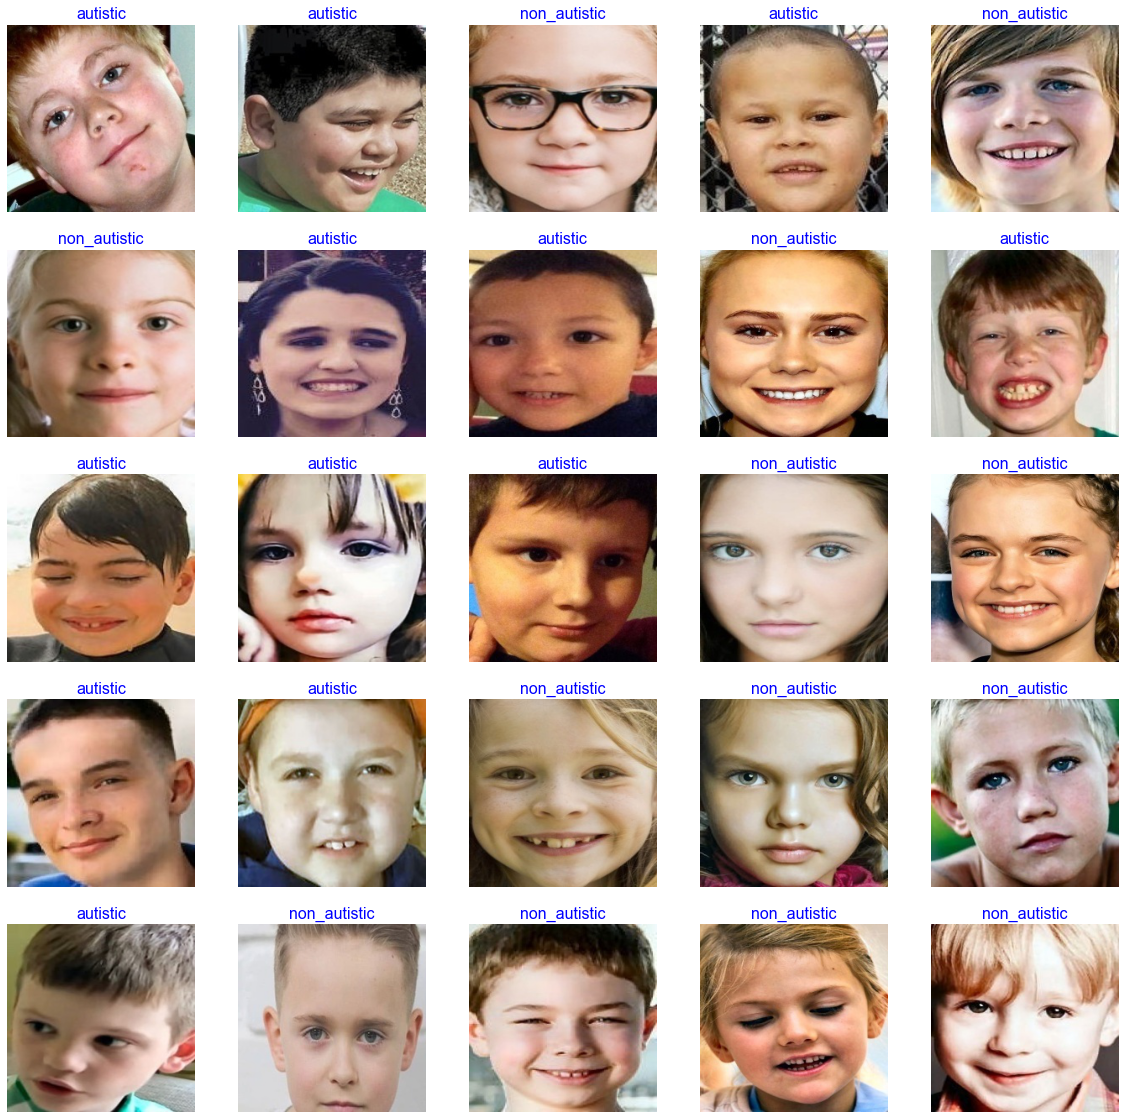

 Starting training using base model InceptionResNetV2 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /25    16.961   72.279  13.83077  59.000   0.00100  0.00100  accuracy  1562.52 

 2 /25    12.119   82.334  10.38657  72.000   0.00100  0.00100  accuracy  1318.07 

 3 /25     9.640   89.393   8.53589  76.000   0.00100  0.00100  accuracy  1365.95 

 4 /25     7.976   91.246  12.86968  72.000   0.00100  0.00100  accuracy  1292.36 

 5 /25     6.562   94.637   6.89186  69.000   0.00100  0.00100  accuracy  1298.08 

 6 /25     5.503   96.175   5.52155  73.000   0.00100  0.00100  val_loss  1366.67 

 7 /25     4.669   97.121   4.69715  76.000   0.00100  0.00100  val_loss  1313.47 

 8 /25     3.985   98.107   4.20124  73.000   0.00100  0.00100  val_loss  1337.54 

 9 /25     3.421   98.147   3.46463  84.000   0.00100  0.00100  val_loss  1322.66 

10 /25     2.962   97.240   3.04722  86.000   0.00100  0.00100  val_loss  1379.20 



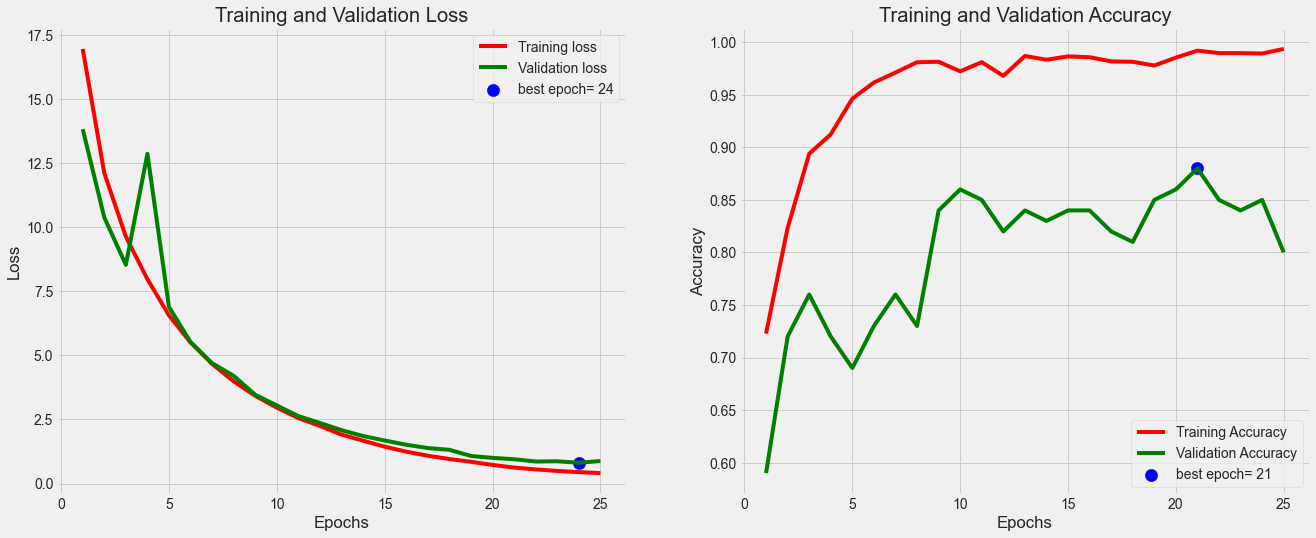

5/5 [==============================] - 24s 5s/step - loss: 0.6750 - accuracy: 0.8900
Model Metrics after Training

         Metric                  Value          

          loss                  0.67501         
        accuracy                0.89000         
accuracy on the test set is 89.00 %



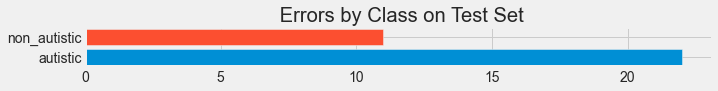

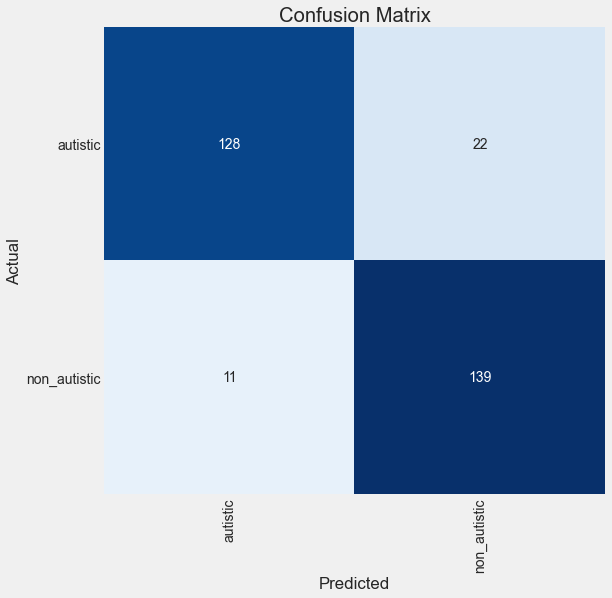

Classification Report:
----------------------
               precision    recall  f1-score   support

    autistic       0.92      0.85      0.89       150
non_autistic       0.86      0.93      0.89       150

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300

Model Metrics after Training

         Metric                  Value          

          loss                  0.67501         
        accuracy                0.89000         
 Process complete



In [14]:
s_dir = r'.'  # main directory that stores the data - function returns dictionary of trained model metrics 
classifier( my_dir=s_dir,
            save_dir=r'./',          # directory to store the trained model and text version of class dictionary of the form {index, class name}
            subject='Autism',         # classifying bird species
            model_type ='InceptionResNetV2',  # select from Mobilenet','MobilenetV2', 'VGG19','InceptionV3', 'ResNet50V2', 'NASNetMobile',
                                     #'DenseNet201,'EfficientNetB0','InceptionResNetV2'
            structure = 3,           # 3 for train,test, valid directories, 2 for train, test directories 1 for a single directory dir  
            v_split=.2,              # only valid if structure =1 or 2. Then it is percentage of training images that will be used for validation
            epochs = 25,               # number of epochs to run the model for
            freeze = False,           # if False all layers of the model are trained for epoch epochs, if True layersof basemodel are not trained
            fine_tune_epochs= 10,     # only used when freeze=True, then all model layers are trained for this value epochs after  initial epochs
            height = 224,             # height of images to be used by the model
            width = 224,              # width of images to be used by the model      
            bands = 3,                # bands in image 3 for rgb 1 for grey scale
            batch_size = 60,          # batch size used in generators
            lr = .001,                # initial learning rate
            patience = 1,             # number of epochs with no performance improvement before learning rate is adjusted
            stop_patience = 4,        # number of times learning rate can be adjusted with performance improvement before stopping training
            threshold = .95,           # float value is training accuracy<threshold adjust lr on accuracy, above threshold adjust on validation loss
            dwell=False,               # if True model weights are set back to best_weights if performance did not improve for current epoch
            factor = .5,              # float <1 factor to multiply current learning rate by if performance does not improve
            dropout = .45,             # dropout float<1 defines dropout factor
            print_code=0 ,           # max number of misclassified files to print out 
            neurons_a= 1024,          # number of neurons in dense layer between base model  and final top classification layer           
            metrics=[])               # create a list of desired metrics Note 'accuracy' metric is automatically added to the list of metrics  

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


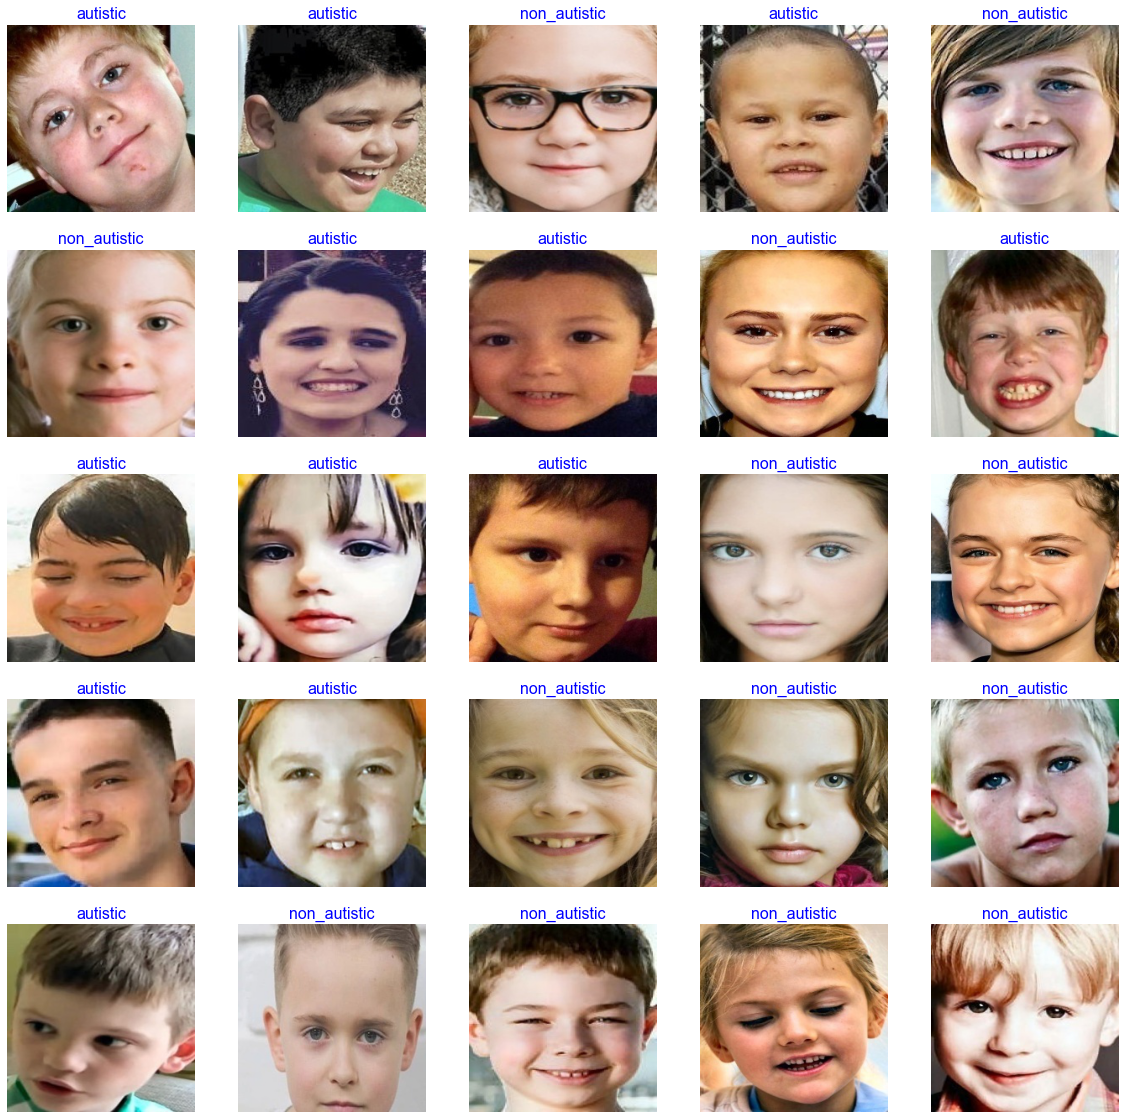

94674944/94668760 [==============================] - 30s 0us/step
 Starting training using base model ResNet50V2 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /25    18.778   68.573  21.98290  68.000   0.00100  0.00100  accuracy  1071.79 

 2 /25    11.751   75.434  10.21350  69.000   0.00100  0.00100  accuracy   927.66 

 3 /25     8.830   78.864   8.63092  63.000   0.00100  0.00100  accuracy   920.94 

 4 /25     6.941   82.295   6.73309  73.000   0.00100  0.00100  accuracy   924.07 

 5 /25     5.514   87.776   5.19924  72.000   0.00100  0.00100  accuracy   923.79 

 6 /25     4.460   91.956   4.23231  76.000   0.00100  0.00100  accuracy   942.97 

 7 /25     3.642   94.322   3.54690  77.000   0.00100  0.00100  accuracy   931.46 

 8 /25     2.996   96.530   3.09392  74.000   0.00100  0.00100  val_loss   950.78 

 9 /25     2.462   97.950   2.52415  82.000   0.00100  0.00100  val_loss   965.82 

10 /25     2.056   97.989

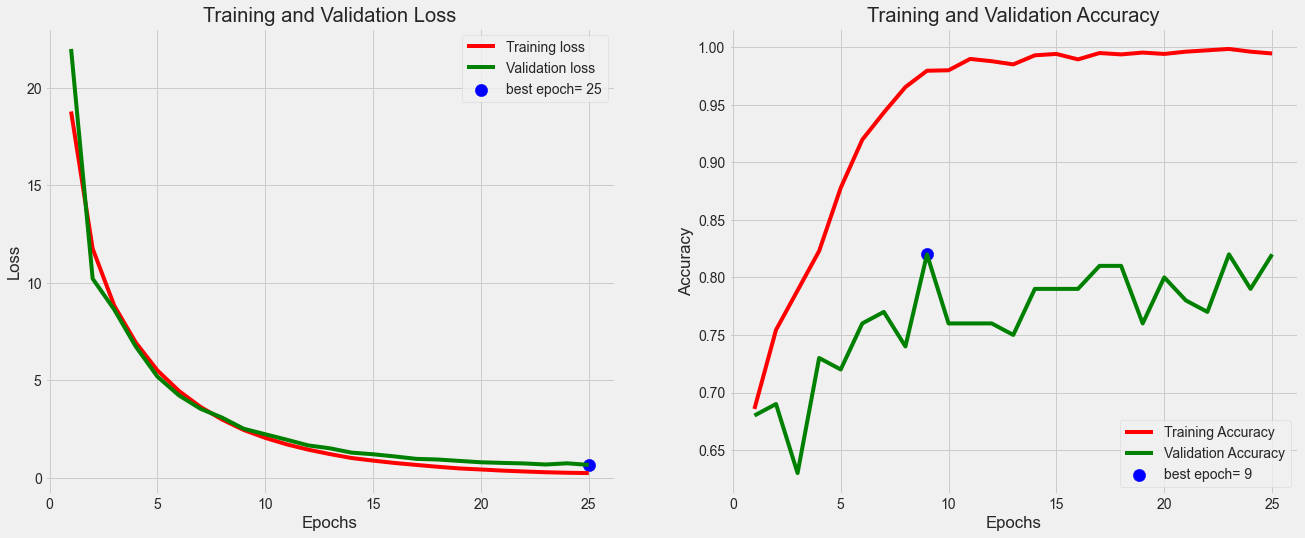

5/5 [==============================] - 12s 2s/step - loss: 0.6344 - accuracy: 0.8200
Model Metrics after Training

         Metric                  Value          

          loss                  0.63444         
        accuracy                0.82000         
accuracy on the test set is 82.00 %



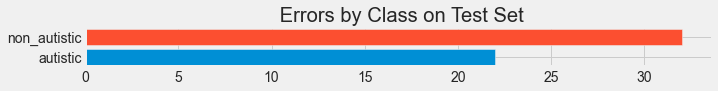

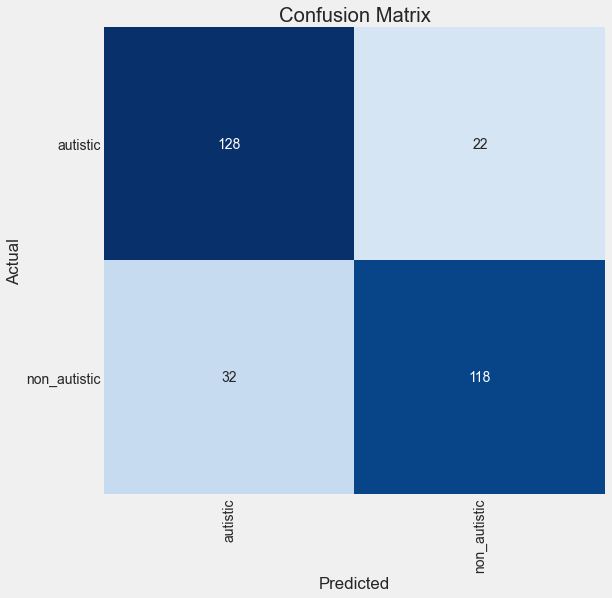

Classification Report:
----------------------
               precision    recall  f1-score   support

    autistic       0.80      0.85      0.83       150
non_autistic       0.84      0.79      0.81       150

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300

Model Metrics after Training

         Metric                  Value          

          loss                  0.63444         
        accuracy                0.82000         
 Process complete



In [15]:
s_dir = r'.'  # main directory that stores the data - function returns dictionary of trained model metrics 
classifier( my_dir=s_dir,
            save_dir=r'./',          # directory to store the trained model and text version of class dictionary of the form {index, class name}
            subject='Autism',         # classifying bird species
            model_type ='ResNet50V2',  # select from Mobilenet','MobilenetV2', 'VGG19','InceptionV3', 'ResNet50V2', 'NASNetMobile',
                                     #'DenseNet201,'EfficientNetB0','InceptionResNetV2'
            structure = 3,           # 3 for train,test, valid directories, 2 for train, test directories 1 for a single directory dir  
            v_split=.2,              # only valid if structure =1 or 2. Then it is percentage of training images that will be used for validation
            epochs = 25,               # number of epochs to run the model for
            freeze = False,           # if False all layers of the model are trained for epoch epochs, if True layersof basemodel are not trained
            fine_tune_epochs= 10,     # only used when freeze=True, then all model layers are trained for this value epochs after  initial epochs
            height = 224,             # height of images to be used by the model
            width = 224,              # width of images to be used by the model      
            bands = 3,                # bands in image 3 for rgb 1 for grey scale
            batch_size = 60,          # batch size used in generators
            lr = .001,                # initial learning rate
            patience = 1,             # number of epochs with no performance improvement before learning rate is adjusted
            stop_patience = 4,        # number of times learning rate can be adjusted with performance improvement before stopping training
            threshold = .95,           # float value is training accuracy<threshold adjust lr on accuracy, above threshold adjust on validation loss
            dwell=False,               # if True model weights are set back to best_weights if performance did not improve for current epoch
            factor = .5,              # float <1 factor to multiply current learning rate by if performance does not improve
            dropout = .45,             # dropout float<1 defines dropout factor
            print_code=0 ,           # max number of misclassified files to print out 
            neurons_a= 1024,          # number of neurons in dense layer between base model  and final top classification layer           
            metrics=[])               # create a list of desired metrics Note 'accuracy' metric is automatically added to the list of metrics  

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


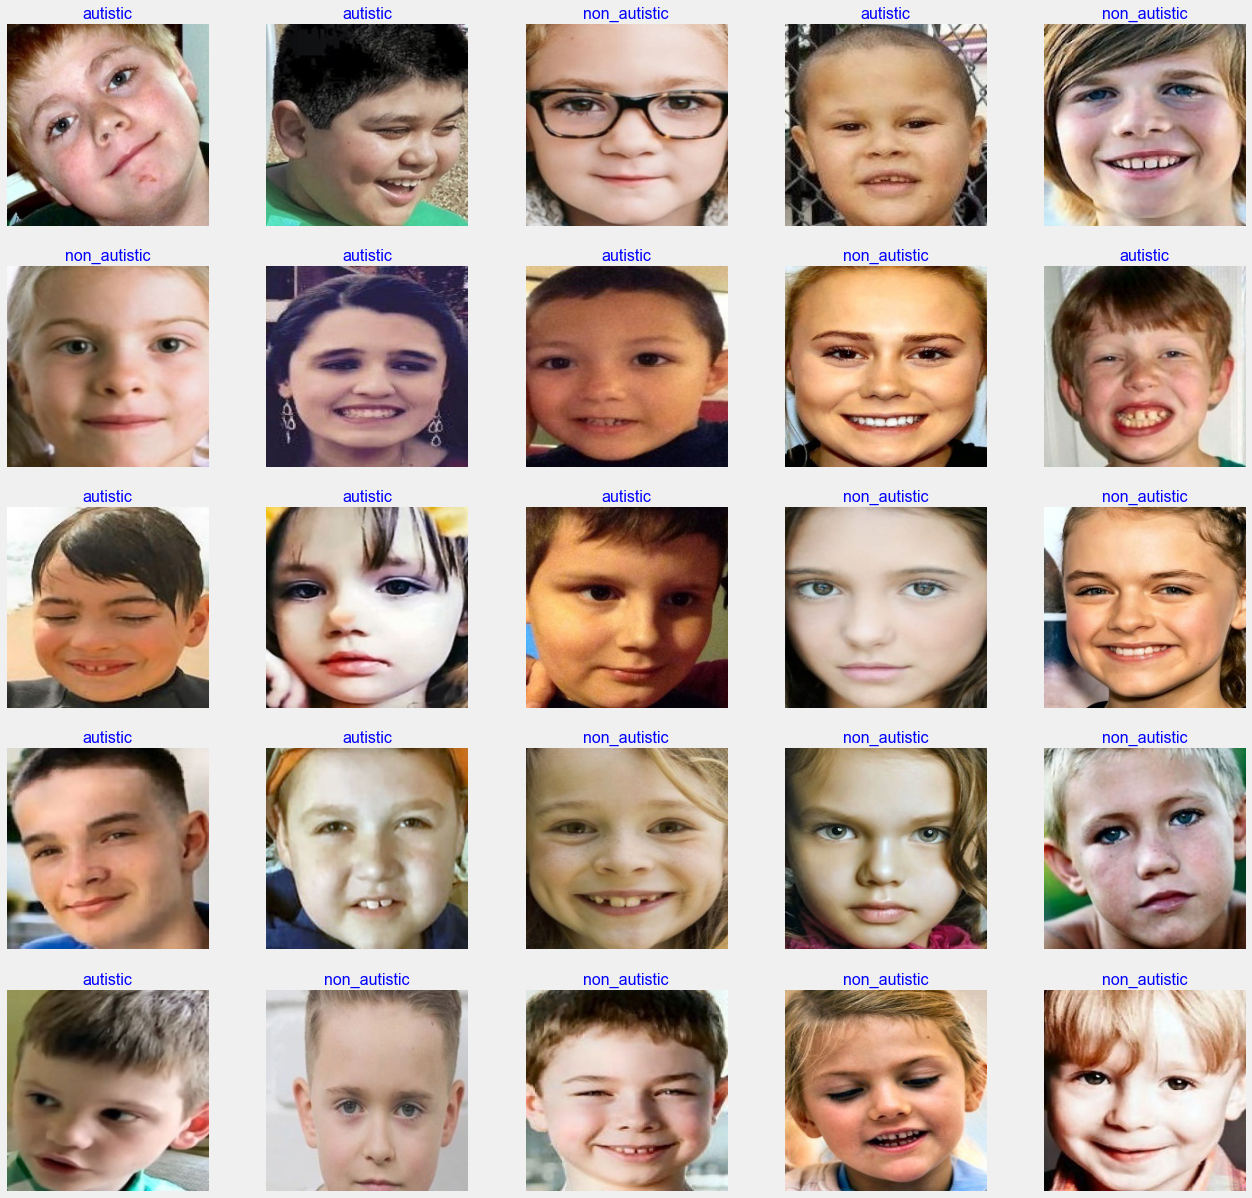

16711680/16705208 [==============================] - 5s 0us/step
 Starting training using base model EfficientNetB0 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /25    16.446   70.899  12.13943  50.000   0.00100  0.00100  accuracy   848.16 

 2 /25     9.761   79.574   8.22586  50.000   0.00100  0.00100  accuracy   720.66 

 3 /25     6.844   83.005   6.06533  50.000   0.00100  0.00100  accuracy   667.44 

 4 /25     5.100   85.726   4.74000  50.000   0.00100  0.00100  accuracy   660.02 

 5 /25     3.921   87.421   3.76612  49.000   0.00100  0.00100  accuracy   656.02 

 6 /25     3.061   90.457   3.04650  60.000   0.00100  0.00100  accuracy   663.88 

 7 /25     2.410   91.088   2.64904  52.000   0.00100  0.00100  accuracy   680.22 

 8 /25     1.911   93.809   2.11924  57.000   0.00100  0.00100  accuracy   660.57 

 9 /25     1.537   95.308   1.88425  53.000   0.00100  0.00100  val_loss   679.87 

10 /25     1.240   95.

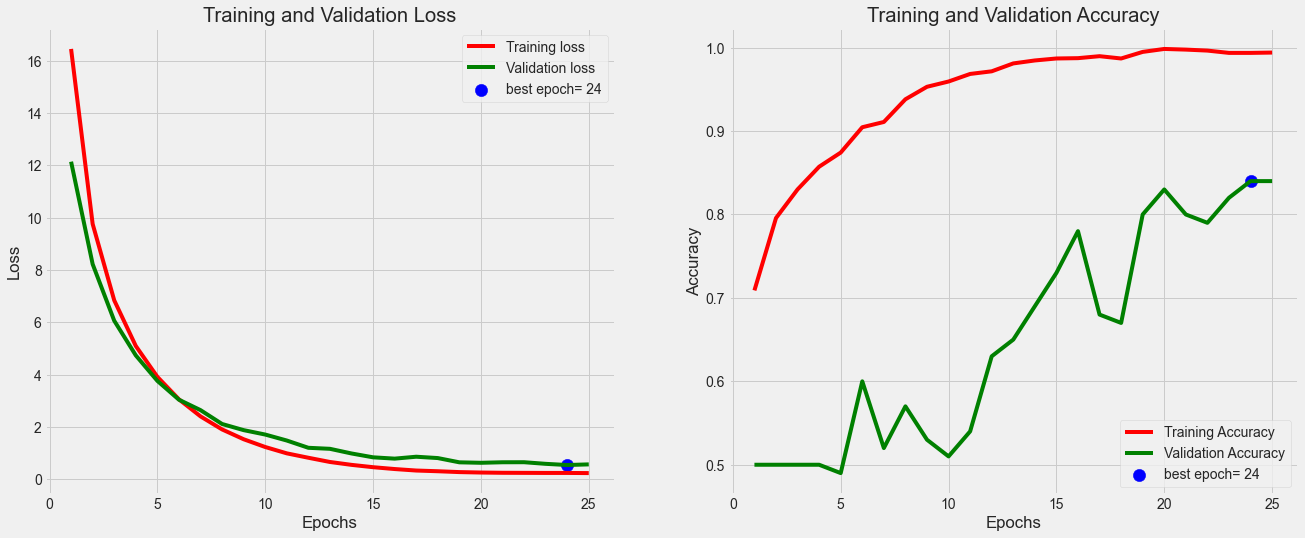

5/5 [==============================] - 11s 2s/step - loss: 0.4493 - accuracy: 0.9033
Model Metrics after Training

         Metric                  Value          

          loss                  0.44934         
        accuracy                0.90333         
accuracy on the test set is 90.33 %



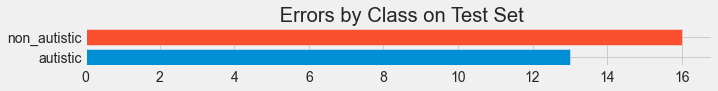

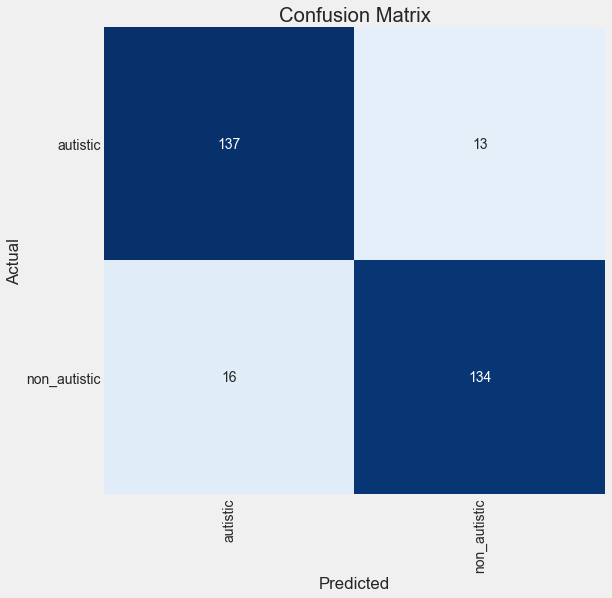

Classification Report:
----------------------
               precision    recall  f1-score   support

    autistic       0.90      0.91      0.90       150
non_autistic       0.91      0.89      0.90       150

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

Model Metrics after Training

         Metric                  Value          

          loss                  0.44934         
        accuracy                0.90333         
 Process complete



In [16]:
s_dir = r'.'  # main directory that stores the data - function returns dictionary of trained model metrics 
classifier( my_dir=s_dir,
            save_dir=r'./',          # directory to store the trained model and text version of class dictionary of the form {index, class name}
            subject='Autism',         # classifying bird species
            model_type ='EfficientNetB0',  # select from Mobilenet','MobilenetV2', 'VGG19','InceptionV3', 'ResNet50V2', 'NASNetMobile',
                                     #'DenseNet201,'EfficientNetB0','InceptionResNetV2'
            structure = 3,           # 3 for train,test, valid directories, 2 for train, test directories 1 for a single directory dir  
            v_split=.2,              # only valid if structure =1 or 2. Then it is percentage of training images that will be used for validation
            epochs = 25,               # number of epochs to run the model for
            freeze = False,           # if False all layers of the model are trained for epoch epochs, if True layersof basemodel are not trained
            fine_tune_epochs= 10,     # only used when freeze=True, then all model layers are trained for this value epochs after  initial epochs
            height = 224,             # height of images to be used by the model
            width = 224,              # width of images to be used by the model      
            bands = 3,                # bands in image 3 for rgb 1 for grey scale
            batch_size = 60,          # batch size used in generators
            lr = .001,                # initial learning rate
            patience = 1,             # number of epochs with no performance improvement before learning rate is adjusted
            stop_patience = 4,        # number of times learning rate can be adjusted with performance improvement before stopping training
            threshold = .95,           # float value is training accuracy<threshold adjust lr on accuracy, above threshold adjust on validation loss
            dwell=False,               # if True model weights are set back to best_weights if performance did not improve for current epoch
            factor = .5,              # float <1 factor to multiply current learning rate by if performance does not improve
            dropout = .45,             # dropout float<1 defines dropout factor
            print_code=0 ,           # max number of misclassified files to print out 
            neurons_a= 1024,          # number of neurons in dense layer between base model  and final top classification layer           
            metrics=[])               # create a list of desired metrics Note 'accuracy' metric is automatically added to the list of metrics  

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


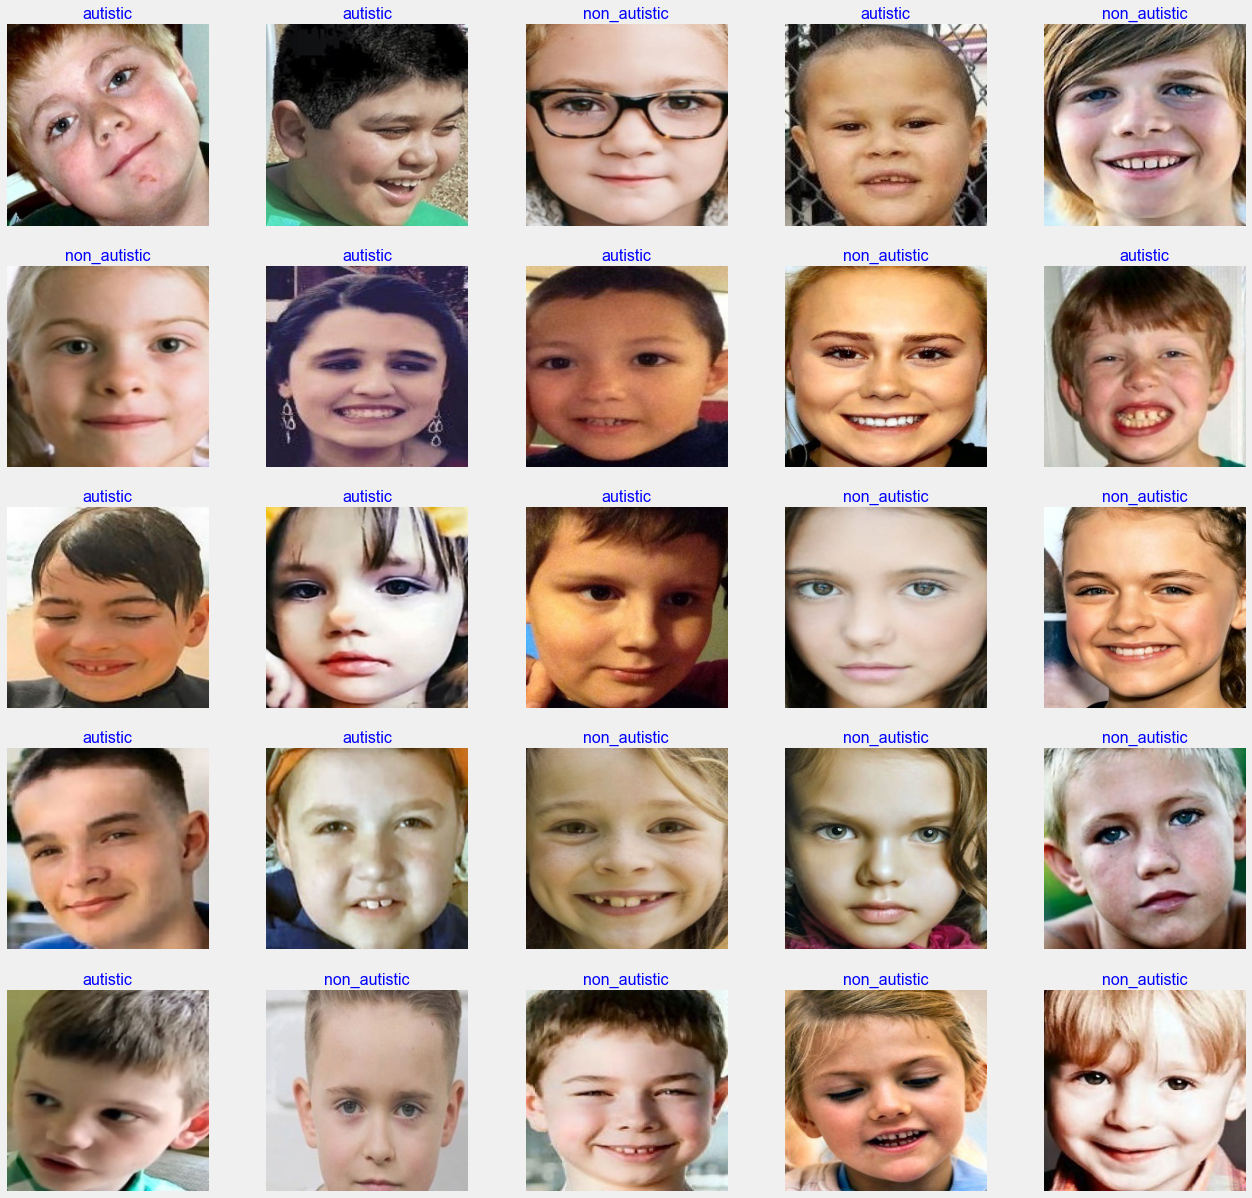

9412608/9406464 [==============================] - 3s 0us/step
 Starting training using base model MobilenetV2 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /25    16.405   72.082  16.01251  52.000   0.00100  0.00100  accuracy   672.40 

 2 /25     9.957   85.134  10.05764  56.000   0.00100  0.00100  accuracy   488.77 

 3 /25     6.710   90.221   7.97688  53.000   0.00100  0.00100  accuracy   491.40 

 4 /25     4.805   92.784   5.85462  54.000   0.00100  0.00100  accuracy   481.30 

 5 /25     3.530   96.964   5.04178  53.000   0.00100  0.00100  val_loss   487.34 

 6 /25     2.684   98.502   4.05854  53.000   0.00100  0.00100  val_loss   484.19 

 7 /25     2.068   98.699   3.58121  53.000   0.00100  0.00100  val_loss   483.11 

 8 /25     1.612   99.566   2.91635  54.000   0.00100  0.00100  val_loss   482.14 

 9 /25     1.269   99.566   2.56768  54.000   0.00100  0.00100  val_loss   486.26 

10 /25     1.010   99.763  

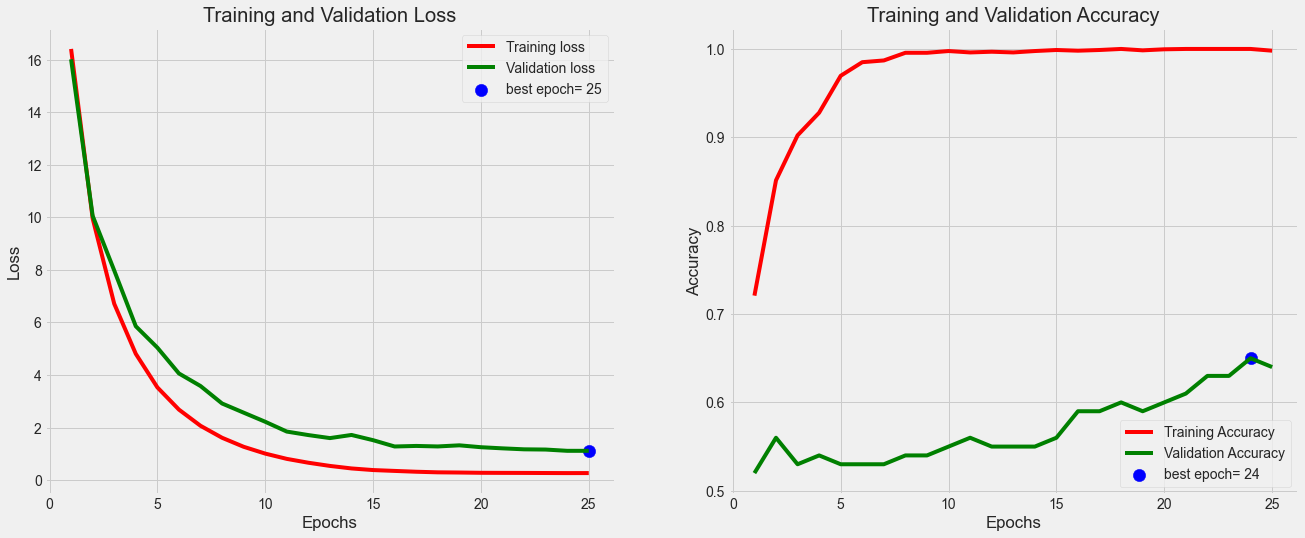

5/5 [==============================] - 10s 2s/step - loss: 0.8685 - accuracy: 0.7033
Model Metrics after Training

         Metric                  Value          

          loss                  0.86847         
        accuracy                0.70333         
accuracy on the test set is 70.33 %



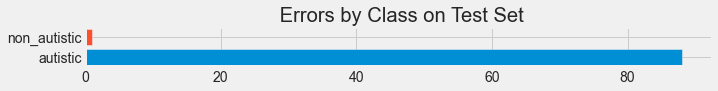

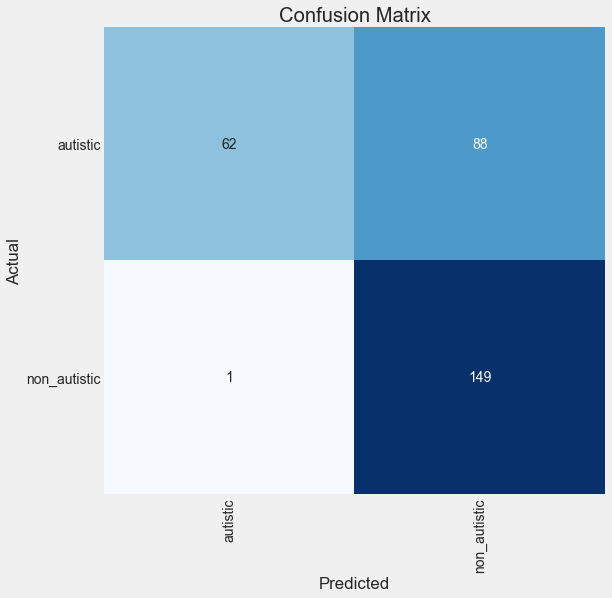

Classification Report:
----------------------
               precision    recall  f1-score   support

    autistic       0.98      0.41      0.58       150
non_autistic       0.63      0.99      0.77       150

    accuracy                           0.70       300
   macro avg       0.81      0.70      0.68       300
weighted avg       0.81      0.70      0.68       300

Model Metrics after Training

         Metric                  Value          

          loss                  0.86847         
        accuracy                0.70333         
 Process complete



In [17]:
s_dir = r'.'  # main directory that stores the data - function returns dictionary of trained model metrics 
classifier( my_dir=s_dir,
            save_dir=r'./',          # directory to store the trained model and text version of class dictionary of the form {index, class name}
            subject='Autism',         # classifying bird species
            model_type ='MobilenetV2',  # select from Mobilenet','MobilenetV2', 'VGG19','InceptionV3', 'ResNet50V2', 'NASNetMobile',
                                     #'DenseNet201,'EfficientNetB0','InceptionResNetV2'
            structure = 3,           # 3 for train,test, valid directories, 2 for train, test directories 1 for a single directory dir  
            v_split=.2,              # only valid if structure =1 or 2. Then it is percentage of training images that will be used for validation
            epochs = 25,               # number of epochs to run the model for
            freeze = False,           # if False all layers of the model are trained for epoch epochs, if True layersof basemodel are not trained
            fine_tune_epochs= 10,     # only used when freeze=True, then all model layers are trained for this value epochs after  initial epochs
            height = 224,             # height of images to be used by the model
            width = 224,              # width of images to be used by the model      
            bands = 3,                # bands in image 3 for rgb 1 for grey scale
            batch_size = 60,          # batch size used in generators
            lr = .001,                # initial learning rate
            patience = 1,             # number of epochs with no performance improvement before learning rate is adjusted
            stop_patience = 4,        # number of times learning rate can be adjusted with performance improvement before stopping training
            threshold = .95,           # float value is training accuracy<threshold adjust lr on accuracy, above threshold adjust on validation loss
            dwell=False,               # if True model weights are set back to best_weights if performance did not improve for current epoch
            factor = .5,              # float <1 factor to multiply current learning rate by if performance does not improve
            dropout = .45,             # dropout float<1 defines dropout factor
            print_code=0 ,           # max number of misclassified files to print out 
            neurons_a= 1024,          # number of neurons in dense layer between base model  and final top classification layer           
            metrics=[])               # create a list of desired metrics Note 'accuracy' metric is automatically added to the list of metrics  